Mean Squared Error (MSE): 86.70650617378584
Median Absolute Error (MedAE): 3.8129441348626614
R² Score: 0.9733949746646534


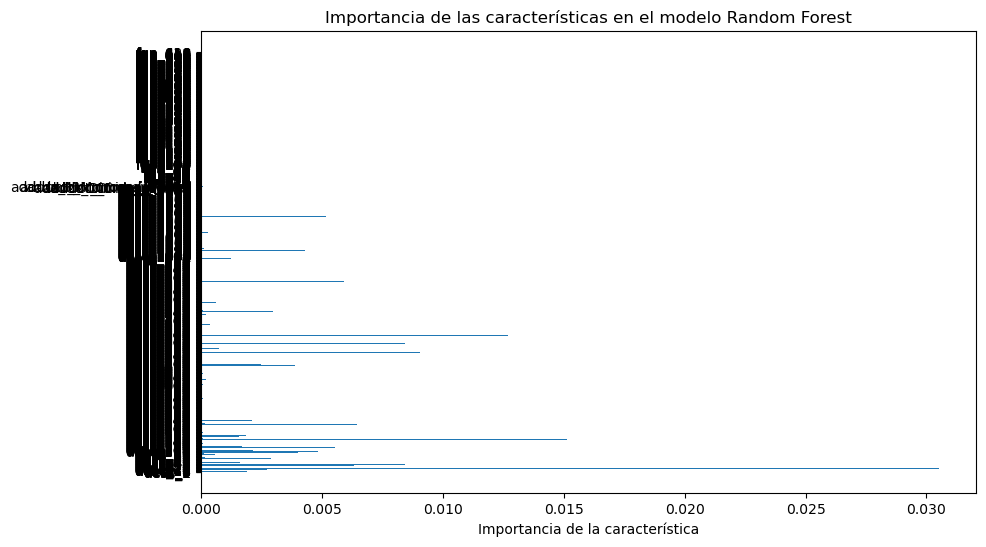

In [16]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Cargar datos
test_data = pd.read_csv("public_test.csv")
train_data = pd.read_csv("public_train.csv")

# Identificar columnas
TARGET = "ccs"
CATEGORICAL_FEATURES = ["adduct"]
NUMERIC_FEATURES = [col for col in train_data.columns if col.startswith("desc_")]
BINARY_FEATURES = [col for col in train_data.columns if col.startswith("fgp_")]

# Separar características y objetivo
x = train_data.drop(columns=[TARGET])  # Características
y = train_data[TARGET]

# Crear el pipeline de preprocesamiento y modelo
def create_preproc_and_model(numeric_features, categorical_features, binary_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder())
            ]), categorical_features),
            ('bin', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler())
            ]), binary_features)
        ])
    
    # Dividir los datos en entrenamiento y prueba
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Asegúrate de ajustar el preprocesador antes de cualquier transformación
    preprocessor.fit(x_train)

    # Transformar los datos de entrenamiento
    x_train_transformed = preprocessor.transform(x_train)
    input_dim = x_train_transformed.shape[1]

    # Crear el modelo RandomForestRegressor
    model = RandomForestRegressor(
    n_estimators=600, 
    max_depth=12,      # Profundidad máxima
    min_samples_split=5,  # Mínimo de muestras para dividir un nodo
    min_samples_leaf=4,  # Mínimo de muestras en cada hoja
    max_features='sqrt',  # Usar la raíz cuadrada de las características
    n_jobs=-1,           # Usar todos los núcleos de CPU disponibles
    random_state=42,     # Para asegurar reproducibilidad
    oob_score=True       # Usar las muestras fuera de la bolsa
)

    # Crear el pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipeline, x_train, x_test, y_train, y_test

# Crear el pipeline
pipeline, x_train, x_test, y_train, y_test = create_preproc_and_model(NUMERIC_FEATURES, CATEGORICAL_FEATURES, BINARY_FEATURES)

# Entrenar el modelo
pipeline.fit(x_train, y_train)

# Hacer predicciones
y_pred = pipeline.predict(x_test)

# Calcular y mostrar MSE y MedAE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

medae = median_absolute_error(y_test, y_pred)
print(f"Median Absolute Error (MedAE): {medae}")

r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)

# Graficar la importancia de las características
model = pipeline.named_steps['model']
importances = model.feature_importances_

# Obtener las características transformadas para mostrarlas en el gráfico
feature_names = (pipeline.named_steps['preprocessor']
                 .transformers_[0][1]
                 .named_steps['scaler']
                 .get_feature_names_out(input_features=NUMERIC_FEATURES).tolist() +
                 pipeline.named_steps['preprocessor']
                 .transformers_[1][1]
                 .named_steps['onehot']
                 .get_feature_names_out(input_features=CATEGORICAL_FEATURES).tolist() +
                 pipeline.named_steps['preprocessor']
                 .transformers_[2][1]
                 .named_steps['scaler']
                 .get_feature_names_out(input_features=BINARY_FEATURES).tolist())

# Crear gráfico de importancia
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Importancia de la característica')
plt.title('Importancia de las características en el modelo Random Forest')
plt.show()
